<a href="https://colab.research.google.com/github/semaHbo/job-clustering-salary-prediction/blob/main/feature_engineering_job_salary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#  Özellik Mühendisliği – Maaş Tahmini Projesi


In [5]:
!pip install pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SalaryPredictionFeatures").getOrCreate()


In [6]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Word2Vec, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import split


In [8]:
from google.colab import drive  #drivea baglanma
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
import os

# datasets klasörünün içini kontrol et
os.listdir("/content/drive/MyDrive/datasets")


['archive.zip']

In [11]:
import zipfile

zip_path = "/content/drive/MyDrive/datasets/archive.zip"
extract_path = "/content/datasets/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [12]:
df = spark.read.csv("/content/datasets/ds_salaries.csv", header=True, inferSchema=True)


In [13]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Word2Vec, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import split, log1p
#kategorik degiskenleri sayisala cevirmek icin gerekli kutuphaneler

In [15]:
from pyspark.sql.functions import log1p, split

# Sütun adını Türkçeleştir
df = df.withColumnRenamed("salary_in_usd", "Maas_USD")

# Log dönüşümünü uygula
df = df.withColumn("Log_Maas_USD", log1p("Maas_USD"))

# Pozisyonu kelimelere ayır (Word2Vec için)
df = df.withColumn("Pozisyon_Token", split(df["job_title"], " "))


In [16]:
df = df.withColumnRenamed("salary_in_usd", "Maas_USD") \
       .withColumnRenamed("job_title", "Pozisyon") \
       .withColumnRenamed("experience_level", "Deneyim_Seviyesi") \
       .withColumnRenamed("employment_type", "Calisma_Tipi") \
       .withColumnRenamed("company_size", "Sirket_Buyuklugu") \
       .withColumnRenamed("remote_ratio", "Uzaktan_Calisma_Orani")


In [17]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Word2Vec, VectorAssembler
from pyspark.ml import Pipeline

# 1. Kategorik sütunlar
kategorik_sutunlar = ["Deneyim_Seviyesi", "Calisma_Tipi", "Sirket_Buyuklugu"]

# 2. StringIndexer ve OneHotEncoder işlemleri
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index") for col in kategorik_sutunlar]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec") for col in kategorik_sutunlar]

# 3. Pozisyon (Word2Vec için daha önce tokenize edilmişti: Pozisyon_Token)
word2vec = Word2Vec(vectorSize=10, minCount=1, inputCol="Pozisyon_Token", outputCol="Pozisyon_Vec")

# 4. Tüm özellikleri birleştir (numerik + kategorik vektörler)
assembler = VectorAssembler(
    inputCols=["Uzaktan_Calisma_Orani", "Pozisyon_Vec"] + [col + "_Vec" for col in kategorik_sutunlar],
    outputCol="features"
)

# 5. Pipeline oluştur
pipeline = Pipeline(stages=indexers + encoders + [word2vec, assembler])

# 6. Pipeline'ı fit et ve veriye uygula
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# 7. Sonuçları görelim
df_transformed.select("features", "Log_Maas_USD").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|features                                                                                                                                                                                                                                              |Log_Maas_USD      |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|[0.0,-0.07917275279760361,0.17954810708761215,-0.13680896162986755,0.11029914766550064,0.03285581059753895,0.16857144236564636,0.0659734308719635,-0.07491271942853928,-0.03279382718028501,-0.1331

In [18]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Word2Vec, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import split, log1p

#ulke sutunlarini sayisallastirarak veri setine tekrar dahil etme
df = df.withColumnRenamed("employee_residence", "Calisan_Ulke") \
       .withColumnRenamed("company_location", "Sirket_Ulke")

#  Log maaş ve pozisyon token'ı
df = df.withColumn("Log_Maas_USD", log1p("Maas_USD"))
df = df.withColumn("Pozisyon_Token", split(df["Pozisyon"], " "))

#  Kategorik sütunları tanımlama
kategorik_sutunlar = [
    "Deneyim_Seviyesi",
    "Calisma_Tipi",
    "Sirket_Buyuklugu",
    "Calisan_Ulke",
    "Sirket_Ulke"
]

# OneHot işlemleri
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index") for col in kategorik_sutunlar]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec") for col in kategorik_sutunlar]

# Pozisyon vektörü
word2vec = Word2Vec(vectorSize=10, minCount=1, inputCol="Pozisyon_Token", outputCol="Pozisyon_Vec")


assembler = VectorAssembler(
    inputCols=["Uzaktan_Calisma_Orani", "Pozisyon_Vec"] + [col + "_Vec" for col in kategorik_sutunlar],
    outputCol="features"
)

# 7. Pipeline tanımı ve uygulaması
pipeline = Pipeline(stages=indexers + encoders + [word2vec, assembler])
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# 8. Sonuç: features + hedef değişken
df_transformed.select("features", "Log_Maas_USD").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|features                                                                                                                                                                                                                                                                               |Log_Maas_USD      |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|(124,[1,2,3,4,5,6,7,8,9,10,12,14,18,23,78],[-0.07917275279760361,0.17954810708761215,-0.13680896

In [25]:
from pyspark.sql.functions import col
import random

# Eğitim ve test setlerini tutacak listeler
train_parts = []
test_parts = []

# Benzersiz kombinasyonları almak icin
combinations = df_transformed.select("Pozisyon", "Deneyim_Seviyesi").distinct().collect()

# Her kombinasyonu döngüyle işleriz
for row in combinations:
    poz = row["Pozisyon"]
    deneyim = row["Deneyim_Seviyesi"]

    subset = df_transformed.filter((col("Pozisyon") == poz) & (col("Deneyim_Seviyesi") == deneyim))
    train_subset, test_subset = subset.randomSplit([0.7, 0.3], seed=random.randint(1, 9999))

    train_parts.append(train_subset)
    test_parts.append(test_subset)

# Eğitim ve test parçalarını birleştirme islemi
train_df = train_parts[0]
for part in train_parts[1:]:
    train_df = train_df.union(part)

test_df = test_parts[0]
for part in test_parts[1:]:
    test_df = test_df.union(part)

# Sonuçları görelim
print(" Eğitim verisi:", train_df.count())
print("🧪Test verisi  :", test_df.count())


🎓 Eğitim verisi: 435
🧪 Test verisi  : 172


In [26]:
!pip install pyspark


In [27]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Model tanımla, eğit, test et
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    numTrees=100,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(train_df)  #modeli egitme
predictions = rf_model.transform(test_df) #tahmin yapma

# Metrikleri hesaplama modelin basarisini  degerlendirme
evaluator_rmse = RegressionEvaluator(
    labelCol="Log_Maas_USD", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(
    labelCol="Log_Maas_USD", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(
    labelCol="Log_Maas_USD", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

(rmse, mae, r2)


(0.5456721626201144, 0.3709083931344195, 0.5350617387294183)

<ipython-input-28-0c0e44fee06f>:21: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


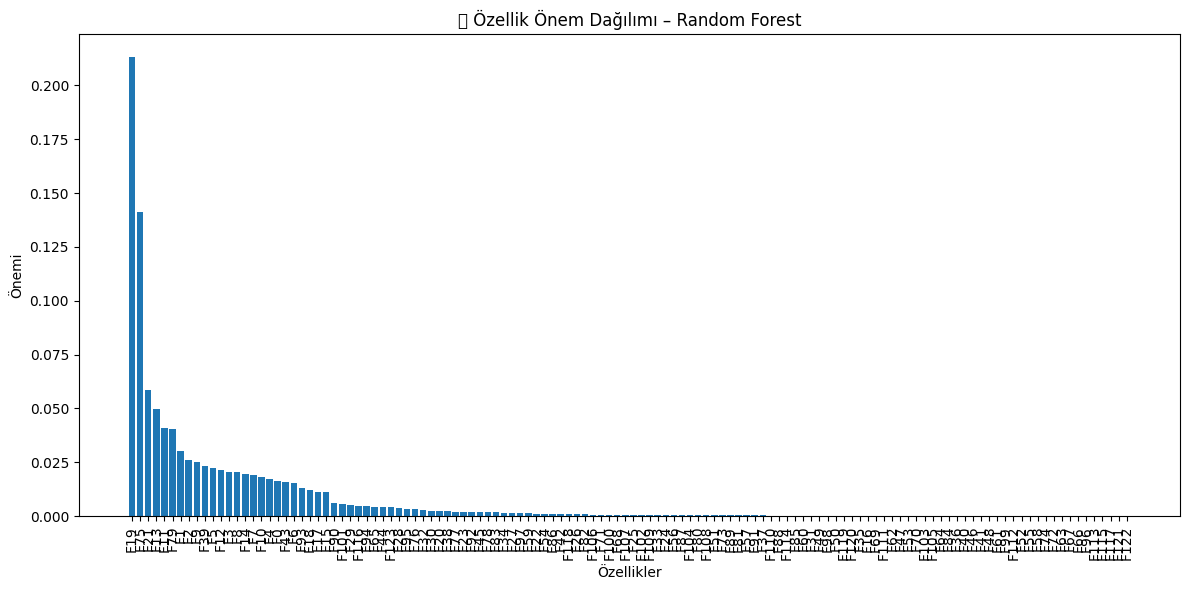

In [28]:
import pandas as pd   #özellik etkisi
import matplotlib.pyplot as plt

# Özellik isimlerini alma
feature_names = rf_model.featureImportances.toArray()
num_features = len(feature_names)

# Görselleştirmek için DataFrame
importance_df = pd.DataFrame({
    "Özellik No": [f"F{i}" for i in range(num_features)],
    "Önemi": rf_model.featureImportances.toArray()
}).sort_values("Önemi", ascending=False)

# Grafik çiz
plt.figure(figsize=(12, 6))
plt.bar(importance_df["Özellik No"], importance_df["Önemi"])
plt.title("Özellik Önem Dağılımı – Random Forest")
plt.xlabel("Özellikler")
plt.ylabel("Önemi")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [29]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    numTrees=100,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(train_df)  # Bu satır kritik


In [31]:
importances = rf_model.featureImportances.toArray()
auto_features = [f"F{i}" for i in range(len(importances))]

import pandas as pd
importances_df = pd.DataFrame({
    "Özellik": auto_features,
    "Önemi": importances
}).sort_values("Önemi", ascending=False).reset_index(drop=True)

importances_df.head(15)


,Özellik,Önemi
0,F19,0.212996
1,F75,0.141342
2,F21,0.058397
3,F13,0.049917
4,F11,0.040946
5,F79,0.040580
6,F1,0.030398
7,F2,0.026270
8,F9,0.024969
9,F39,0.023144


In [33]:
!pip install pyspark


In [37]:
from pyspark import StorageLevel

df_transformed.persist(StorageLevel.MEMORY_AND_DISK)
df_transformed.count()  # bu satır cache’i aktif eder


607

In [40]:
train_df.write.mode("overwrite").parquet("/content/train_df.parquet")#dag problemi icin amac zamani kisaltmak
test_df.write.mode("overwrite").parquet("/content/test_df.parquet")


In [41]:
train_df = spark.read.parquet("/content/train_df.parquet")
test_df = spark.read.parquet("/content/test_df.parquet")


In [42]:
#ilk tuning islemi
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Modeli tanımla
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    numTrees=50,
    maxDepth=5,
    seed=42
)

# Eğitimi başlatma
model = rf.fit(train_df)

# Tahmin yapma
predictions = model.transform(test_df)

# R² skorunu hesaplama
evaluator = RegressionEvaluator(
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    metricName="r2"
)

r2_score = evaluator.evaluate(predictions)
print(" R² Skoru (numTrees=50, maxDepth=5):", round(r2_score, 4))


🎯 R² Skoru (numTrees=50, maxDepth=5): 0.5265


In [43]:
#ikinci tuning denemesi
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    numTrees=100,
    maxDepth=10,
    seed=42
)

model = rf.fit(train_df)

predictions = model.transform(test_df)

evaluator = RegressionEvaluator(
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    metricName="r2"
)

r2_score = evaluator.evaluate(predictions)
print(" R² Skoru (numTrees=100, maxDepth=10):", round(r2_score, 4))


 R² Skoru (numTrees=100, maxDepth=10): 0.5407


In [44]:
#ücüncü tuning denemsi
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    numTrees=150,
    maxDepth=15,
    seed=42
)

model = rf.fit(train_df)

predictions = model.transform(test_df)

evaluator = RegressionEvaluator(
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    metricName="r2"
)

r2_score = evaluator.evaluate(predictions)
print(" R² Skoru (numTrees=150, maxDepth=15):", round(r2_score, 4))


🎯 R² Skoru (numTrees=150, maxDepth=15): 0.5333
